# Hydrocarbon prospective well logs analysis and curve reconstruction with Python/Sklearn.

By: Miguel La Cruz.

In [23]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import functions

In [24]:
#Import wells data
Well_1 = pd.read_csv("../data/raw/Well_1_mincols.csv", sep=";")
Well_3 = pd.read_csv("../data/raw/Well_3_mincols.csv", sep=";")

## Intro

As we know, ***machine learning*** has endless applications and we can use it to develop optimal solutions to diverse problems.

In the field of petrophysics has a considerable utility and everyday is in constant growth, applied to the cluster analysis to determine sedimentary facies, generation of synthetic well curves, and so on.

The present analysis approachs the posibility of repairing low cuality curves (logs) available of a well, either for presence of washouts or other factors that may disturb the response of before mentioned curves.

### Data

For the present analysis we will use well log data in .las format, provided by the petrophysics consultant enterprise **INTER-ROCK**, without availability of ubication as it will be used for research and educational purpouses.

Data consists in a set of well log information, including two wells that have the best features for didactic representation. These wells will be named as **"Well_1"** and **"Well_3"**.

**NOTE**: Sometimes we represent graphically Well_1 and sometimes Well_3, in order to select the best images for the analysis.

### Data importing

As is mentioned before the data we will use is in ***.las*** format, so we will transform it to ***.csv*** in order to work easily with it. To do that, we open the files with ***Microsoft Office Excel*** and select which columns we will use to analize wells and generate curve reconstruction models.

Data we will keep:

* **DEPTH**: Depth in (Ft)
* **CAL**: Caliper diameter in (In)
* **NPHI**: Neutron porosity in (Frac)
* **DT**: Sonic in (ms/in)
* **GR**: Gamma ray in ºAPI
* **RHOB**: Density in (g/cm3)
* **RLLD**: Deep electric log in (ohm/mts)
* **RT**: Electric log in (ohm/mts)
* **BS**: Bit size in (In)

**Total data (Well_1)**

<img src="img/excel_img_1.png" alt="eximg_1" width="800"/>

**Columns to use (Well_1)**

<img src="img/excel_img_2.png" alt="eximg_1" width="700"/>

Litology and interpretation data are eliminated, as this information will not be useful to repair the log we selected to represent the process, which in this case will be NPHI (neutron porosity) as its very sensitive to enviromental factors.

### Data preparring

Lets check briefly each well information.

In [25]:
Well_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11093 entries, 0 to 11092
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DEPTH   11093 non-null  object 
 1   CAL     11093 non-null  object 
 2   NPHI    11093 non-null  float64
 3   DT      11093 non-null  object 
 4   GR      11093 non-null  object 
 5   RHOB    11093 non-null  float64
 6   RLLD    11093 non-null  object 
 7   RT      11093 non-null  object 
 8   BS      11093 non-null  object 
dtypes: float64(2), object(7)
memory usage: 780.1+ KB


In [26]:
Well_1.head()

,DEPTH,CAL,NPHI,DT,GR,RHOB,RLLD,RT,BS
0,28.540.000,117.301,0.1689,661.330,629.330,24.639,73.194,47.113,92.500
1,28.545.000,128.258,0.2028,661.171,646.600,24.792,14.814,0.7520,92.500
2,28.550.000,116.805,0.1879,643.786,669.060,25.137,33.782,19.726,92.500
3,28.555.000,106.683,0.1669,627.153,700.470,25.864,136.513,91.723,92.500
4,28.560.000,106.684,0.1056,624.420,719.610,26.516,355.276,269.653,92.500


First we can notice is the presence of "object" type columns which wouldn't let us operate matematically with them, as well as extremely defective values as they're too high or atypical. This is produced by the data conversion to **.csv**, so we can proceed to repair it.

#### Data conversion "object" to "float"

In [27]:
#Well_1
Well_1[["DEPTH","CAL","DT","GR", "RLLD", "RT", "BS"]] = \
    Well_1[["DEPTH","CAL","DT","GR", "RLLD", "RT", "BS"]].apply(functions.col_to_float, axis=1)

#Well_3
Well_3[["DEPTH","CAL","DT","GR","RHOB","RLLD","RT", "BS"]] = \
    Well_3[["DEPTH","CAL","DT","GR","RHOB","RLLD", "RT", "BS"]].apply(functions.col_to_float, axis=1)

#### Taking log values to their real value

In [28]:
#Well_1
Well_1["DEPTH"] = Well_1["DEPTH"]/10000
Well_1["CAL"] = Well_1["CAL"]/10000
Well_1["DT"] = Well_1["DT"]/10000
Well_1["GR"] = Well_1["GR"]/10000
Well_1["RHOB"] = Well_1["RHOB"]/10
Well_1["RLLD"] = Well_1["RLLD"]/10000
Well_1["RT"] = Well_1["RT"]/10000
Well_1["BS"] = Well_1["BS"]/10000

#Well_3
Well_3["DEPTH"] = Well_3["DEPTH"]/10000
Well_3["CAL"] = Well_3["CAL"]/10000
Well_3["DT"] = Well_3["DT"]/10000
Well_3["GR"] = Well_3["GR"]/10000
Well_3["RHOB"] = Well_3["RHOB"]/10000
Well_3["RLLD"] = Well_3["RLLD"]/10000
Well_3["RT"] = Well_3["RT"]/10000
Well_3["BS"] = Well_3["BS"]/10000

First look of well data.

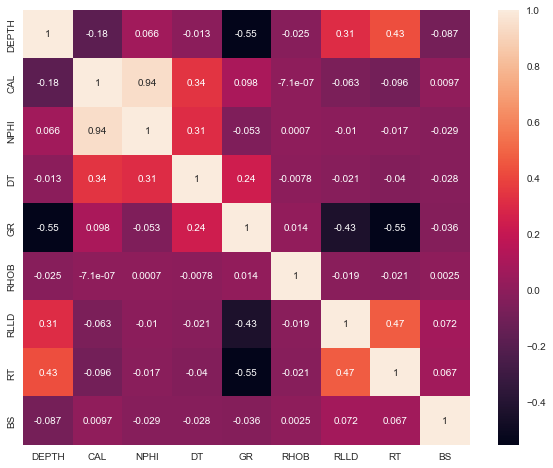

In [29]:
#Well_3 correlations
plt.style.use("seaborn")
plt.figure(figsize=(10,8))
sns.heatmap(Well_3.corr(), annot= True);

We can notice low correlation with our target (NPHI) except with the caliper log, which tell us that the NPHI log is quite affected by washouts.

Now we proceed to look at the data distribution so we can determinate if a well could have representative data of the other one. We use GR log as its usually representative.

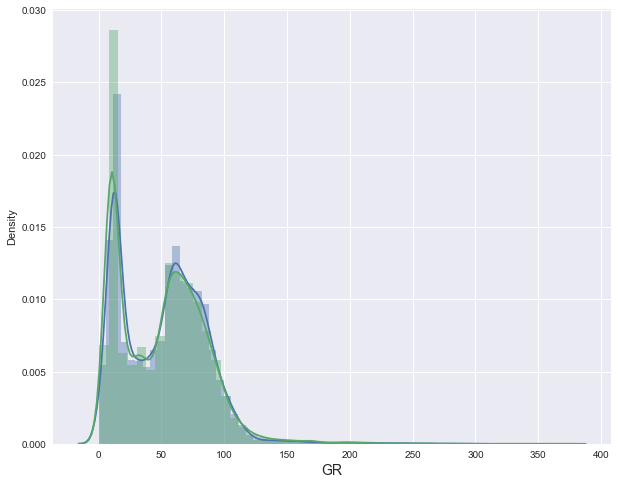

In [30]:
plt.figure(figsize= (10,8))

sns.distplot(Well_1["GR"])
sns.distplot(Well_3["GR"])
plt.xlabel("GR", fontsize=14);

Data distribution is pretty similar, therefore ,we can expect similar behavior in both wells. We will evaluate generating a model from one well to repair the NPHI log of the other one, but first leets look how much the enviromental conditions affect NPHI log.

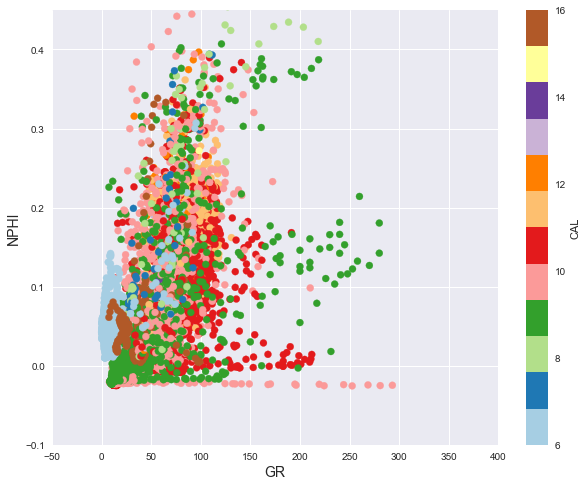

In [31]:
plt.figure(figsize= (10,8))
# Plot conditions
plt.scatter(x="GR", y="NPHI", data=Well_1, c="CAL", vmin=6, vmax=16, cmap="Paired")

# X limits
plt.xlim(-50, 400)

# Y limits
plt.ylim(-0.10, 0.45)

# Axis labels
plt.ylabel("NPHI", fontsize=14)
plt.xlabel("GR", fontsize=14)

plt.colorbar(label="CAL")

plt.show()

In [32]:
Well_3.head()

,DEPTH,CAL,NPHI,DT,GR,RHOB,RLLD,RT,BS
0,2910.0,8.803,-0.035,61.3679,64.181,999.000,8.080,13.2102,9.875
1,2910.5,8.805,-0.035,61.0326,64.677,2.356,8.856,14.7835,9.875
2,2911.0,8.791,-0.035,60.7296,63.758,2.371,9.899,17.4435,9.875
3,2911.5,8.762,-0.035,60.4639,61.310,2.385,9.728,17.1287,9.875
4,2912.0,8.723,-0.035,60.4930,62.578,2.384,8.593,14.5229,9.875


We can look how the NPHI values are affected in relation to the caliper values being the bitsize equal to 9.875 (BS), having multiple values above BS value. We have also values below, which can indicate presence of casing, so we will proceed to evaluate curves briefly in a first curve plot.

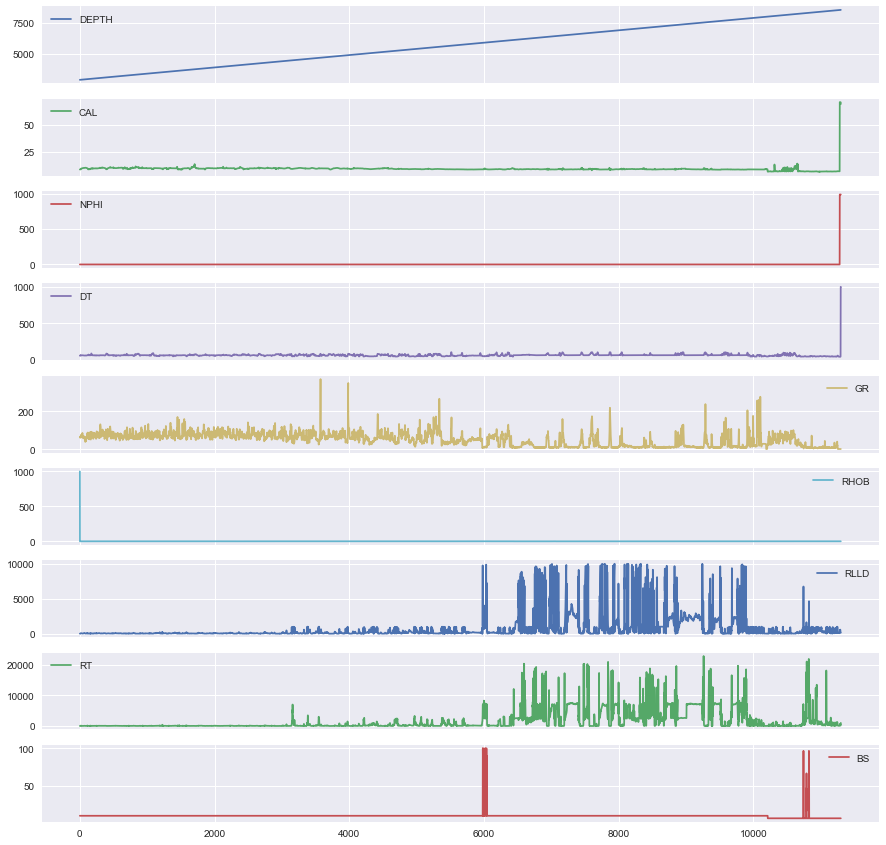

In [33]:
Well_3.plot(subplots= True, figsize= (15,15));

We have multiple values near 1000 (999) which in this case indicates null values, and changing values in the bitsize which should be a constant value, therefore we proceed to eliminate them.

In [34]:
#Well_1
Well_1["BS"] = np.where(Well_1["BS"] > 15, 9.25, Well_1["BS"])

#Well_3
Well_3["CAL"] = np.where(Well_3["CAL"] > 50, Well_3["CAL"]/10, Well_3["CAL"])
Well_3["NPHI"] = functions.nan_as_nan(Well_3["NPHI"], 990) #Null values to "None"
Well_3["RHOB"] = functions.nan_as_nan(Well_3["RHOB"], 999)  #so we can work with them easily
Well_3["DT"] = functions.nan_as_nan(Well_3["DT"], 999)
Well_3["RT"] = functions.nan_as_nan(Well_3["RT"], 999)
Well_3["BS"] = np.where(Well_3["BS"] > 10, 9.875, Well_3["BS"])

#Well_3 values to float

Well_3["NPHI"] = Well_3["NPHI"].astype(float)
Well_3["DT"] = Well_3["DT"].astype(float)
Well_3["RHOB"] = Well_3["RHOB"].astype(float)
Well_3["RT"] = Well_3["RT"].astype(float)

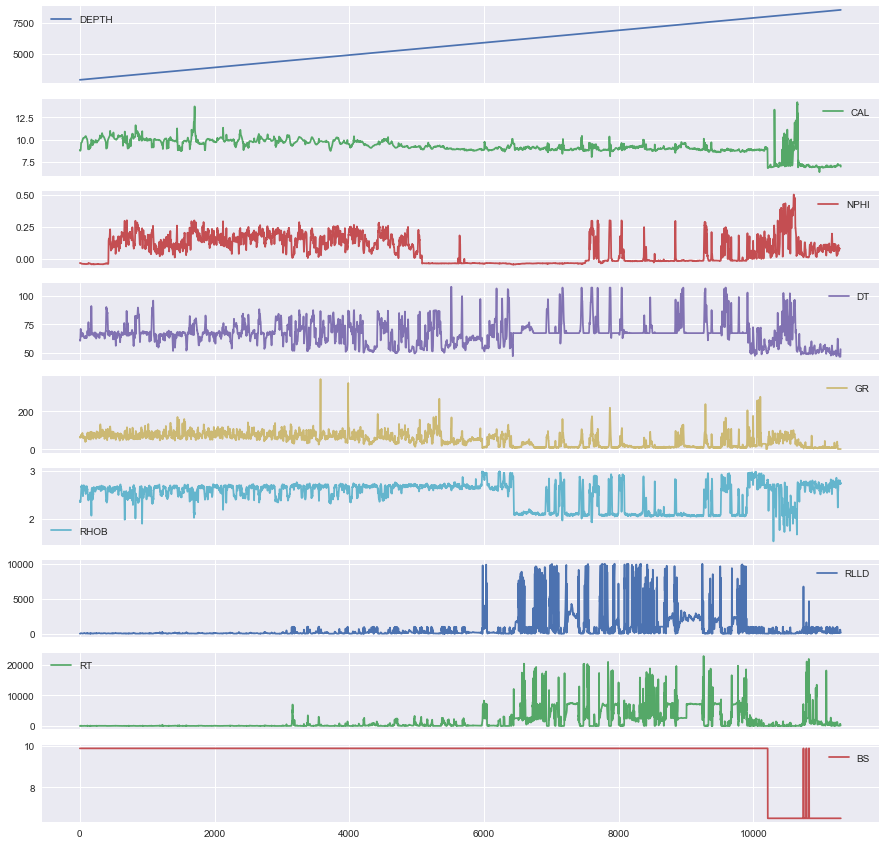

In [35]:
Well_3.plot(subplots= True, figsize= (15,15));

In [36]:
Well_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11301 entries, 0 to 11300
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DEPTH   11301 non-null  float64
 1   CAL     11301 non-null  float64
 2   NPHI    11284 non-null  float64
 3   DT      11298 non-null  float64
 4   GR      11301 non-null  float64
 5   RHOB    11300 non-null  float64
 6   RLLD    11301 non-null  float64
 7   RT      11299 non-null  float64
 8   BS      11301 non-null  float64
dtypes: float64(9)
memory usage: 794.7 KB


Still having null values in Well_3, lets proceed to eliminate them.

In [37]:
Well_3 = Well_3.dropna()

After data cleaning we can perform a thoroughful analysis, taking a look of the wells vs deep.

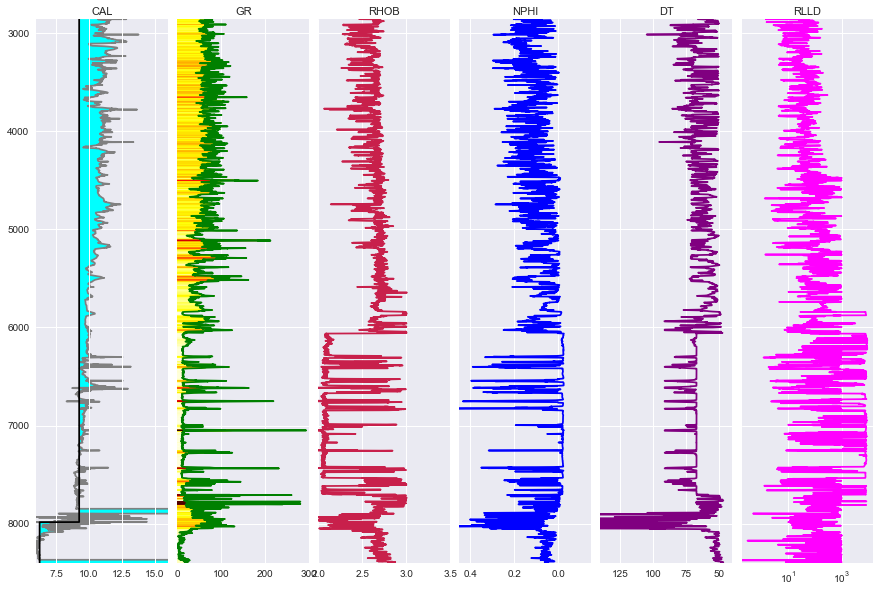

In [38]:
#Well 3 plots
fig, axes = plt.subplots(figsize= (15,10))

#Each log plot
ax0 = plt.subplot2grid((1,6), (0,0), rowspan=1, colspan=1)
ax1 = plt.subplot2grid((1,6), (0,1), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((1,6), (0,2), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((1,6), (0,3), rowspan=1, colspan=1)
ax4 = ax0.twiny() #Both logs in the same track
ax5 = plt.subplot2grid((1,6), (0,4), rowspan=1, colspan=1)
ax6 = plt.subplot2grid((1,6), (0,5), rowspan=1, colspan=1)


#Caliper plot
ax0.plot("CAL", "DEPTH", data= Well_1, color= "gray")
ax0.set_xlabel("CAL")
ax0.set_xlim(6,16)
ax0.set_ylim(8400,2854)
ax0.grid(10)

ax0.fill_betweenx(Well_1["DEPTH"], Well_1["BS"], Well_1["CAL"],where=Well_1["CAL"]>=Well_1["BS"],facecolor='cyan')#Washout shading

#GR plot
ax1.plot("GR", "DEPTH", data= Well_1, color= "green")
ax1.set_xlabel("GR")
ax1.set_xlim(0,300)
ax1.set_ylim(8400,2854)
ax1.grid(10)

#GR sequential shading
left_value = 0
right_value = 300
span = abs(left_value-right_value)

cmap=plt.get_cmap('hot_r')

color_index = np.arange(left_value, right_value, span/100)
for index in sorted(color_index):
    index_value = (index - left_value)/span
    color = cmap(index_value)
    ax1.fill_betweenx(Well_1['DEPTH'], left_value, Well_1['GR'], where=Well_1['GR']>=index, color=color)

#RHOB plot
ax2.plot("RHOB", "DEPTH", data= Well_1, color= (200/255.0, 32/255.0, 75/255.0))
ax2.set_xlabel("RHOB")
ax2.set_xlim(2,3.5)
ax2.set_ylim(8400,2854)
ax2.grid(10)

#NPHI plot
ax3.plot("NPHI", "DEPTH", data= Well_1, color= "blue")
ax3.set_xlabel("NPHI")
ax3.set_xlim(0.45,-0.15)
ax3.set_ylim(8400,2854)
ax3.grid(10)

#BS plot
ax4.plot("BS", "DEPTH", data= Well_1, color= "black")
ax4.set_xlim(6,16)
ax4.set_ylim(8400,2854)
ax4.grid(10)

#DT plot
ax5.plot("DT", "DEPTH", data= Well_1, color= "purple")
ax5.set_xlabel("DT")
ax5.set_xlim(140,40)
ax5.set_ylim(8400,2854)
ax5.grid(10)

#RLLD plot
ax6.plot("RLLD", "DEPTH", data= Well_1, color= "magenta")
ax6.set_xlabel("RLLD")
ax6.semilogx()#Logarithmic scale
ax6.set_ylim(8400,2854)
ax6.grid(10)

#Label position on top
ax0.xaxis.set_label_position("top")
ax1.xaxis.set_label_position("top")
ax2.xaxis.set_label_position("top")
ax3.xaxis.set_label_position("top")
ax4.xaxis.set_label_position("top")
ax5.xaxis.set_label_position("top")
ax6.xaxis.set_label_position("top")

#Eliminate labels between tracks
plt.setp(ax1.get_yticklabels(), visible = False)
plt.setp(ax2.get_yticklabels(), visible = False)
plt.setp(ax3.get_yticklabels(), visible = False)
plt.setp(ax4.get_xticklabels(), visible = False)
plt.setp(ax5.get_yticklabels(), visible = False)
plt.setp(ax6.get_yticklabels(), visible = False)

#Close distance between tracks
fig.subplots_adjust(wspace = 0.07)

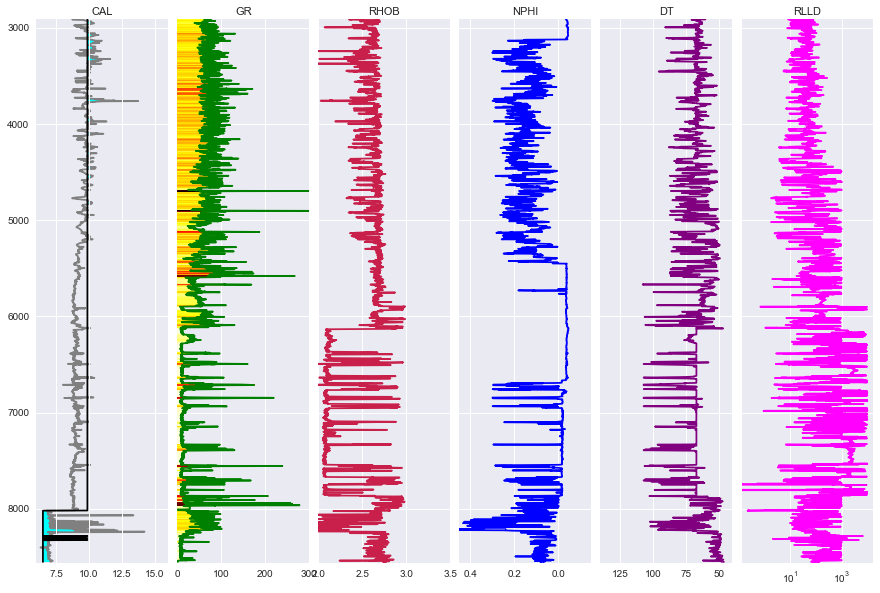

In [39]:
#Well 3 plots
fig, axes = plt.subplots(figsize= (15,10))

#Each log plot
ax0 = plt.subplot2grid((1,6), (0,0), rowspan=1, colspan=1)
ax1 = plt.subplot2grid((1,6), (0,1), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((1,6), (0,2), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((1,6), (0,3), rowspan=1, colspan=1)
ax4 = ax0.twiny() #Coloca ambos registros en el mismo track
ax5 = plt.subplot2grid((1,6), (0,4), rowspan=1, colspan=1)
ax6 = plt.subplot2grid((1,6), (0,5), rowspan=1, colspan=1)


#Caliper plot
ax0.plot("CAL", "DEPTH", data= Well_3, color= "gray")
ax0.set_xlabel("CAL")
ax0.set_xlim(6,16)
ax0.set_ylim(8560,2910)
ax0.grid(10)

ax0.fill_betweenx(Well_3["DEPTH"], Well_3["BS"], Well_3["CAL"],where=Well_3["CAL"]>=Well_3["BS"],facecolor='cyan')#Sombreado derrumbe

#GR plot
ax1.plot("GR", "DEPTH", data= Well_3, color= "green")
ax1.set_xlabel("GR")
ax1.set_xlim(0,300)
ax1.set_ylim(8560,2910)
ax1.grid(10)

#GR sequential shading
left_value = 0
right_value = 300
span = abs(left_value-right_value)

cmap=plt.get_cmap('hot_r')

color_index = np.arange(left_value, right_value, span/100)
for index in sorted(color_index):
    index_value = (index - left_value)/span
    color = cmap(index_value)
    ax1.fill_betweenx(Well_3['DEPTH'], left_value, Well_3['GR'], where=Well_3['GR']>=index, color=color)

#RHOB plot
ax2.plot("RHOB", "DEPTH", data= Well_3, color= (200/255.0, 32/255.0, 75/255.0))
ax2.set_xlabel("RHOB")
ax2.set_xlim(2,3.5)
ax2.set_ylim(8560,2910)
ax2.grid(10)

#NPHI plot
ax3.plot("NPHI", "DEPTH", data= Well_3, color= "blue")
ax3.set_xlabel("NPHI")
ax3.set_xlim(0.45,-0.15)
ax3.set_ylim(8560,2910)
ax3.grid(10)

#BS Plot
ax4.plot("BS", "DEPTH", data= Well_3, color= "black")
ax4.set_xlim(6,16)
ax4.set_ylim(8560,2910)
ax4.grid(10)

#DT Plot
ax5.plot("DT", "DEPTH", data= Well_3, color= "purple")
ax5.set_xlabel("DT")
ax5.set_xlim(140,40)
ax5.set_ylim(8560,2910)
ax5.grid(10)

#RLLD plot
ax6.plot("RLLD", "DEPTH", data= Well_3, color= "magenta")
ax6.set_xlabel("RLLD")
ax6.semilogx()
ax6.set_ylim(8560,2910)
ax6.grid(10)

#Label position on top
ax0.xaxis.set_label_position("top")
ax1.xaxis.set_label_position("top")
ax2.xaxis.set_label_position("top")
ax3.xaxis.set_label_position("top")
ax4.xaxis.set_label_position("top")
ax5.xaxis.set_label_position("top")
ax6.xaxis.set_label_position("top")

#Eliminate labels between tracks
plt.setp(ax1.get_yticklabels(), visible = False)
plt.setp(ax2.get_yticklabels(), visible = False)
plt.setp(ax3.get_yticklabels(), visible = False)
plt.setp(ax4.get_xticklabels(), visible = False)
plt.setp(ax5.get_yticklabels(), visible = False)
plt.setp(ax6.get_yticklabels(), visible = False)

#Close distance between tracks
fig.subplots_adjust(wspace = 0.07)


Wash-outs are present in most of Well_1, so we will use the Well_3 data to generate a model that allow us to repair NPHI logs in both wells. First we can check lithology to have a better idea of what we are analyzing (lithology from software).

* **Well_3 lithology**

<div>
<p style = 'text-align:center;'>
<img src="img/lito.png" alt="eximg_1" width="200"/>
</p>
</div>


Lets create "flags" so we can highlight areas with anomalies.

In [40]:
#Creating positives and negatives flags for wells

#Well_1
Well_1["positive_flag"] = Well_1[Well_1["NPHI"] > 0.30]["NPHI"]
Well_1["negative_flag"] = Well_1[Well_1["NPHI"] < 0]["NPHI"]

#Well_3
Well_3["positive_flag"] = Well_3[Well_3["NPHI"] > 0.30]["NPHI"]
Well_3["negative_flag"] = Well_3[Well_3["NPHI"] < 0]["NPHI"]

Lets visualize where are the anomalies located.

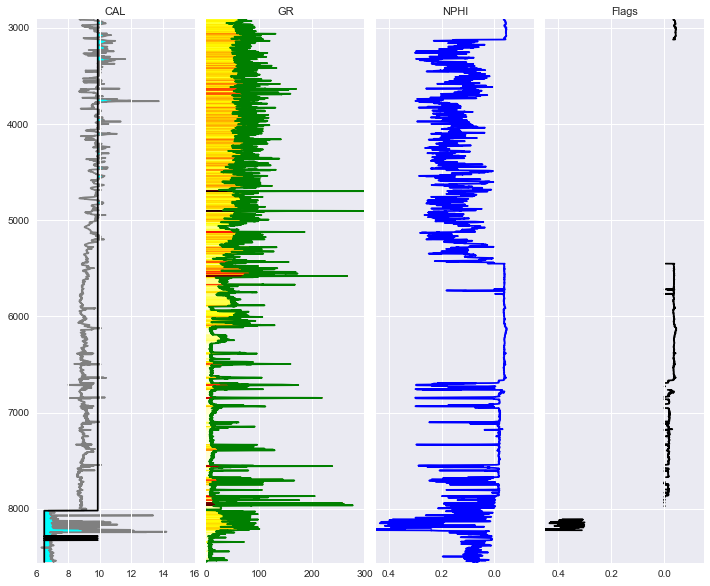

In [41]:
#Well 3 plots
fig, axes = plt.subplots(figsize= (15,10))

ax0 = plt.subplot2grid((1,5), (0,0), rowspan=1, colspan=1)
ax1 = plt.subplot2grid((1,5), (0,1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((1,5), (0,2), rowspan=1, colspan=1)
ax7 = plt.subplot2grid((1,5), (0,3), rowspan=1, colspan=1)
ax8 = ax7.twiny()
ax4 = ax0.twiny()


ax0.plot("CAL", "DEPTH", data= Well_3, color= "gray")
ax0.set_xlabel("CAL")
ax0.set_xlim(6,16)
ax0.set_ylim(8560,2910)
ax0.grid(10)

ax0.fill_betweenx(Well_3["DEPTH"], Well_3["BS"], Well_3["CAL"],where=Well_3["CAL"]>=Well_3["BS"],facecolor='cyan')

ax1.plot("GR", "DEPTH", data= Well_3, color= "green")
ax1.set_xlabel("GR")
ax1.set_xlim(0,300)
ax1.set_ylim(8560,2910)
ax1.grid(10)

left_value = 0
right_value = 300
span = abs(left_value-right_value)

cmap=plt.get_cmap('hot_r')

color_index = np.arange(left_value, right_value, span/100)
for index in sorted(color_index):
    index_value = (index - left_value)/span
    color = cmap(index_value)
    ax1.fill_betweenx(Well_3['DEPTH'], left_value, Well_3['GR'], where=Well_3['GR']>=index, color=color)

ax3.plot("NPHI", "DEPTH", data= Well_3, color= "blue")
ax3.set_xlabel("NPHI")
ax3.set_xlim(0.45,-0.15)
ax3.set_ylim(8560,2910)
ax3.grid(10)

ax4.plot("BS", "DEPTH", data= Well_3, color= "black")
ax4.set_xlim(6,16)
ax4.set_ylim(8560,2910)
ax4.grid(10)

ax7.plot("negative_flag", "DEPTH", data= Well_3, color= "black")
ax7.set_xlabel("Flags")
ax7.set_xlim(0.45,-0.15)
ax7.set_ylim(8560,2910)
ax7.grid(10)

ax8.plot("positive_flag", "DEPTH", data= Well_3, color= "black")
ax8.set_xlim(0.45,-0.15)
ax8.set_ylim(8560,2910)
ax8.grid(10)

ax0.xaxis.set_label_position("top")
ax1.xaxis.set_label_position("top")
ax3.xaxis.set_label_position("top")
ax4.xaxis.set_label_position("top")
ax7.xaxis.set_label_position("top")

plt.setp(ax1.get_yticklabels(), visible = False)
plt.setp(ax2.get_yticklabels(), visible = False)
plt.setp(ax3.get_yticklabels(), visible = False)
plt.setp(ax4.get_xticklabels(), visible = False)
plt.setp(ax7.get_yticklabels(), visible = False)
plt.setp(ax8.get_xticklabels(), visible = False)
plt.setp(ax5.get_yticklabels(), visible = False)
fig.subplots_adjust(wspace = 0.07)

As we can see one of the main responsible of anomalies in Well_3 is casing, we can also skip salt values as isn't a interest area and in the top of the well we also have anomalies with not too much importance, so we can also eliminate it to proceed with the model creation.

#### Later we fix defective values for the model creation

In [42]:
#Well_1
Well_1["BS"] = np.where(Well_1["BS"] > 15, 9.25, Well_1["BS"])

#Well_3
Well_3["CAL"] = np.where(Well_3["CAL"] > 50, Well_3["CAL"]/10, Well_3["CAL"])
Well_3["NPHI"] = functions.nan_as_nan(Well_3["NPHI"], 990)
Well_3["RHOB"] = functions.nan_as_nan(Well_3["RHOB"], 999)
Well_3["DT"] = functions.nan_as_nan(Well_3["DT"], 999)
Well_3["RT"] = functions.nan_as_nan(Well_3["RT"], 999)
Well_3["BS"] = np.where(Well_3["BS"] > 10, 9.875, Well_3["BS"])


Well_3["NPHI"] = Well_3["NPHI"].astype(float)
Well_3["DT"] = Well_3["DT"].astype(float)
Well_3["RHOB"] = Well_3["RHOB"].astype(float)
Well_3["RT"] = Well_3["RT"].astype(float)

In [43]:
#RLLD to logaritmic so it can fit better in the model

Well_1["RLLD_log"] = np.log(Well_1["RLLD"])
Well_3["RLLD_log"] = np.log(Well_3["RLLD"])

Applying masks we work with a new DataFrame to not affect the previous one, which has values that doesn't appear in the flags. We will use Well_3 to generate the model after processing, as it has better hole conditions.

In [44]:
mask1 = Well_3[Well_3["positive_flag"].isna()] #First mask
Well_3_data = Well_3[Well_3["positive_flag"].isna()]#Values that aren't in the flag
Well_3_data = Well_3_data.drop("positive_flag", axis=1)#Drop flag so we don't include it in the model

mask2 = Well_3_data[Well_3_data["negative_flag"].isna()]#Second mask
Well_3_data = mask2
Well_3_data = Well_3_data.drop("negative_flag", axis=1)

Well_3_data = Well_3_data.set_index("DEPTH")#Set DEPTH as index, as we will don't use it to calculate any other feature.
Well_3_data.replace([np.inf, -np.inf], np.nan, inplace=True)#Drop infinite values, as they aren't accepted as input in a model.
Well_3_data.dropna(inplace=True)#Drop NaNs (Again)

#### Model (Polinomic Linear Regression)

Lets check improvement of correlations.

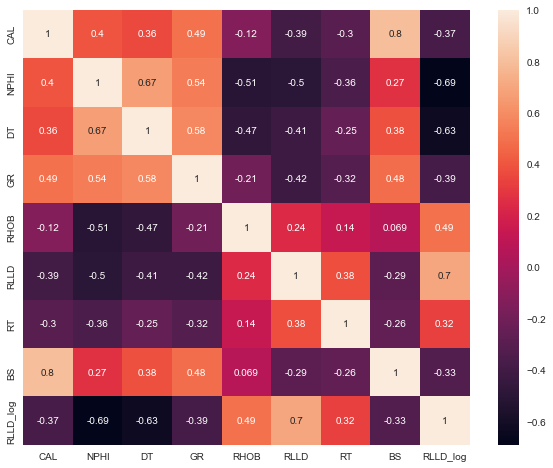

In [45]:
plt.figure(figsize=(10,8))
sns.heatmap(Well_3_data.corr(), annot=True);

After several model tests, we selected the polynomial linear regression model as it is the one that best repairs the NPHI data, without falling into overfitting and adding values ​​as a result of casing.

In [46]:
#Importing modules for model generation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

In [47]:
#Train test split

X = Well_3_data[["DT","GR","RHOB", "RLLD_log"]]
Y = Well_3_data["NPHI"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [48]:
#Pipeline model
model_pipeline = Pipeline(steps = [
    ("scaler", StandardScaler()),
    ("poly_transform", PolynomialFeatures(degree = 2)),
    ("regression", LinearRegression())])


model_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('poly_transform', PolynomialFeatures()),
                ('regression', LinearRegression())])

Lets evaluate the model.

In [49]:
print("MAE: ", mean_absolute_error(Y_test,model_pipeline.predict(X_test)))

MAE:  0.033146973879185686


We get a mean absolute error of 0.033 or 3.3%, which is quite acceptable, and can be improved with core data and further analyzed after calculating permeability and other wellbore properties.

We then evaluate the importance of each feature.

In [50]:
print(X_train.columns) #Checking columns
X_train_poly_columns = ["C", "DT", "GR", "RHOB", "RLLD_log", "DT2", "GR2", "RHOB2", "RLLD_log2", "DT*GR", "DT*RHOB", "DT*RLLD_log",
                        "GR*RHOB", "GR*RLLD_log", "RHOB*RLLD_log"]#Polynomical 2º order features
print(X_train_poly_columns)

Index(['DT', 'GR', 'RHOB', 'RLLD_log'], dtype='object')
['C', 'DT', 'GR', 'RHOB', 'RLLD_log', 'DT2', 'GR2', 'RHOB2', 'RLLD_log2', 'DT*GR', 'DT*RHOB', 'DT*RLLD_log', 'GR*RHOB', 'GR*RLLD_log', 'RHOB*RLLD_log']


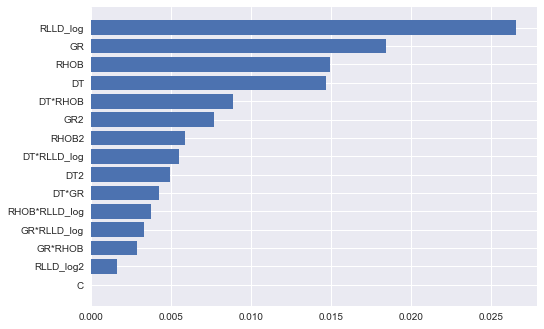

In [51]:
features = pd.DataFrame(abs(model_pipeline[2].coef_), X_train_poly_columns, columns=["coefficient"])
features = features.sort_values("coefficient", ascending=True)
plt.barh(features.index, features.coefficient);

RLLD_log is the most important feature.

#### Lets now try the model

Lets check how the model works to repair the Well_1 NPHI log.

In [62]:
model_pipeline.fit(X, Y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('poly_transform', PolynomialFeatures()),
                ('regression', LinearRegression())])

In [52]:
Well_1.drop(["positive_flag", "negative_flag"], axis=1, inplace=True) #Eliminate flags
Well_1.replace([np.inf, -np.inf], np.nan, inplace=True)#Eliminate infs
Well_1.dropna(inplace=True)#Eliminate NaNs

In [53]:
#Train test

X_w1 = Well_1[["DT","GR","RHOB", "RLLD_log"]]
Y_w1 = Well_1["NPHI"]

In [63]:
Well_1["NPHI_poly_predict"] = model_pipeline.predict(X_w1) #NPHI Well_3 prediction

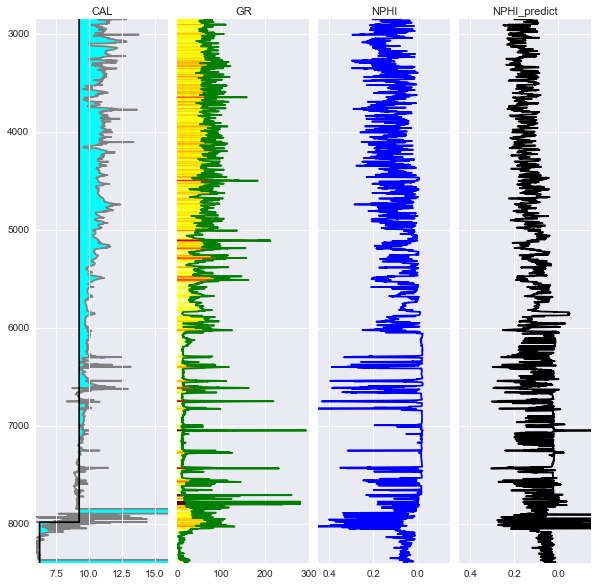

In [64]:
fig, axes = plt.subplots(figsize= (15,10))

ax0 = plt.subplot2grid((1,6), (0,0), rowspan=1, colspan=1)
ax1 = plt.subplot2grid((1,6), (0,1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((1,6), (0,2), rowspan=1, colspan=1)
ax9 = plt.subplot2grid((1,6), (0,3), rowspan=1, colspan=1)
ax4 = ax0.twiny()


ax0.plot("CAL", "DEPTH", data= Well_1, color= "gray")
ax0.set_xlabel("CAL")
ax0.set_xlim(6,16)
ax0.set_ylim(8400,2854)
ax0.grid(10)

ax0.fill_betweenx(Well_1["DEPTH"], Well_1["BS"], Well_1["CAL"],where=Well_1["CAL"]>=Well_1["BS"],facecolor='cyan')

ax1.plot("GR", "DEPTH", data= Well_1, color= "green")
ax1.set_xlabel("GR")
ax1.set_xlim(0,300)
ax1.set_ylim(8400,2854)
ax1.grid(10)

left_value = 0
right_value = 300
span = abs(left_value-right_value)

cmap=plt.get_cmap('hot_r')

color_index = np.arange(left_value, right_value, span/100)
for index in sorted(color_index):
    index_value = (index - left_value)/span
    color = cmap(index_value)
    ax1.fill_betweenx(Well_1['DEPTH'], left_value, Well_1['GR'], where=Well_1['GR']>=index, color=color)

ax3.plot("NPHI", "DEPTH", data= Well_1, color= "blue")
ax3.set_xlabel("NPHI")
ax3.set_xlim(0.45,-0.15)
ax3.set_ylim(8400,2854)
ax3.grid(10)

ax4.plot("BS", "DEPTH", data= Well_1, color= "black")
ax4.set_xlim(6,16)
ax4.set_ylim(8400,2854)
ax4.grid(10)

ax9.plot("NPHI_poly_predict", "DEPTH", data= Well_1, color= "black")
ax9.set_xlabel("NPHI_predict")
ax9.set_xlim(0.45,-0.15)
ax9.set_ylim(8400,2854)
ax9.grid(10)

ax0.xaxis.set_label_position("top")
ax1.xaxis.set_label_position("top")
ax3.xaxis.set_label_position("top")
ax9.xaxis.set_label_position("top")

plt.setp(ax1.get_yticklabels(), visible = False)
plt.setp(ax3.get_yticklabels(), visible = False)
plt.setp(ax4.get_xticklabels(), visible = False)
plt.setp(ax9.get_yticklabels(), visible = False)
fig.subplots_adjust(wspace = 0.07)

We can observe how in the upper section of the well, the NPHI is corrected quite well, presenting values ​​within an acceptable range for the type of lithology present, with the exception of the casing zone, since not being trained for this case it responds in a way erroneous, although it corrects the maximum values ​​a little, the negative values ​​shoot up. This can be corrected by applying thresholds or editing the curve based on the trend of minimum values ​​of the original curve.

Finally, we observe the usefulness of this procedure (procedure applied both to NPHI and to other curves to carry out the characterization)(visualization in software).

<img src="img/characterizationp.png" alt="eximg_1" width="600"/>

We see how the reading in the corrected log in the casing zone improves considerably, showing the presence of an area of ​​interest that we could not previously see, as well as with a multimineral evaluation we verify the similarity that it has with the lithology of the well.

Having a good characterization in turn can help us determine the direction in which the well should be tilted if necessary.

 ![imagen](./img/deviation.png)